# **Desafio - Clasificacion de calidad de ramen**

#**0.Importamos las librerias**

In [ ]:
import pandas as pd
import numpy as np
#Viz
import matplotlib.pyplot as plt
import seaborn as sns
#Normalizacion, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#Split
from sklearn.model_selection import train_test_split
#Algoritmos
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
#Metricas de evaluacion
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score
#Busqueda de hiperparametros
from sklearn.model_selection import GridSearchCV
#Montamos el drive
from google.colab import drive
drive.mount("/content/drive")
#SMOTE
from imblearn.over_sampling import SMOTE
#PCA
from sklearn.decomposition import PCA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Machine Learning/4.Aprendizaje supervisado y no supervisado Parte III/Desafio/ramen-ratings.xlsx")

#**1.Realizar un análisis exhaustivo de calidad de datos para identificar y tratar posibles valores faltantes, valores atípicos y errores en los datos. Garantizar que el conjunto de datos esté limpio y preparado para su posterior procesamiento y entrenamientode los modelos.**

In [ ]:
print(df.shape)
print("")
df.head(5)

(2580, 7)



,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [ ]:
#Primeras transformaciones de nombres de columnas
new_names = ["review","brand","variety","type","country","stars","top_ten"]
df.columns = new_names

In [ ]:
df.dtypes

review      int64
brand      object
variety    object
type       object
country    object
stars      object
top_ten    object
dtype: object

In [ ]:
nulls = df.isna().sum()
print(f"La cantidad de nulos por columna en el dataframe son:\n{nulls}")

La cantidad de nulos por columna en el dataframe son:
review        0
brand         0
variety       0
type          2
country       0
stars         0
top_ten    2539
dtype: int64


Como podemos ver la columna Top Ten presenta una excesiva cantidad de nulos, sin embargo no podemos eliminarlos ya que la data es pequeña y tendremos que trabajarlos de otra forma.

In [ ]:
df.duplicated().sum() #No hay duplicados

0

Revisamos los registros por columna

In [ ]:
for columna in df.columns:
  print(f"Existen {df[columna].nunique()} Valores en la columna {columna}:")
  print(df[columna].unique())
  print("")

Existen 2580 Valores en la columna review:
[2580 2579 2578 ...    3    2    1]

Existen 355 Valores en la columna brand:
['New Touch' 'Just Way' 'Nissin' 'Wei Lih' "Ching's Secret"
 'Samyang Foods' 'Acecook' 'Ikeda Shoku' "Ripe'n'Dry" 'KOKA' 'Tao Kae Noi'
 'Yamachan' 'Nongshim' 'TRDP' 'Binh Tay' 'Paldo' 'Jackpot Teriyaki'
 'Yum-Mie' 'MyKuali' 'Ottogi' 'Sichuan Guangyou' 'Lipton' 'Lele'
 'Fujiwara' 'Uni-President' 'Maruchan' 'Prima' 'Sokensha' 'Takamori'
 'Guava Story' 'Samurai Ramen' 'Ogasawara' 'Pringles' "Mom's Dry Noodle"
 'Maggi' 'Indomie' 'Happy Cook' 'The Ramen Rater Select' 'TTL' 'E-Zee'
 'Kiki Noodle' 'Tokyo Noodle' 'GGE' 'Myojo' 'Sau Tao' 'Wang' 'Daifuku'
 'Master Kong' "World O' Noodle" 'Kang Shi Fu' 'Mum Ngon' 'Fashion Food'
 'Dream Kitchen' 'Ajinatori' "Dr. McDougall's" 'Ve Wong' 'Super Bihun'
 'Xiuhe' 'Little Cook' 'Shirakiku' "Mama Pat's" 'Goku-Uma'
 'Sichuan Baijia' 'Liang Cheng Mai' 'Gefen' 'Hua Feng' 'Pulmuone'
 'Liu Quan' 'Daikoku' 'Chuan Wei Wang' 'Wai Wai' 'Kamfen' 

Consideraciones:


*   review = No debiese ser relevante para el entrenamiento al ser solo un identificador unico.
*   brand = Se explorará la mejor forma de transformarla para poder mantenerla en las features.
*   variety = con más de 2400 variables unicas, la transformación a dummies no sería la mejor opción.
*   type = La transformaremos a una variable binaria con dummies
*   country = la usamos para obtener continentes y asi, reduciendo su dimension pero manteniendo sus caracteristicas, ser utilizara y tranformada a binaria.
*   stars = Se utilizará para crear el target
*   topten = Se evaluará como se puede conservar, ya que tiene más del 90% de valores nulos e imputando esos valores para mantenerlos, no sería fiel a la realidad.


Limpieza, transformacion y visualizacion de datos

In [ ]:
df["stars"] = df["stars"].replace("Unrated",0) #Remplazamos los 3 valores unrated por 0
df["stars"] = df["stars"].astype(float) #Transformamos la columna
df["type"] = df["type"].replace("nan","Pack") #Remplazamos los nan por los valores más comunes de la columna

#Crearemos un diccionario para una nueva columna que nos permita analizar por continentes
country_dict = {'Japan': "Asia",'Taiwan': "Asia",'USA': "North America",'India': "Asia",'South Korea': "Asia",'Singapore': "Asia",'Thailand': "Asia",'Hong Kong': "Asia",'Vietnam': "Asia",'Ghana': "Africa",
    'Malaysia': "Asia",'Indonesia': "Asia",'China': "Asia",'Nigeria': "Africa",'Germany': "Europe",'Hungary': "Europe",'Mexico': "North America",'Fiji': "Oceania",'Australia': "Oceania",'Pakistan': "Asia",
    'Bangladesh': "Asia",'Canada': "North America",'Nepal': "Asia",'Brazil': "South America",'UK': "Europe",'Myanmar': "Asia",'Netherlands': "Europe",'United States': "North America",'Cambodia': "Asia",
    'Finland': "Europe",'Sarawak': "Asia",'Philippines': "Asia",'Sweden': "Europe",'Colombia': "South America",'Estonia': "Europe",'Holland': "Europe",'Poland': "Europe",'Dubai': "Asia"}

df["continent"] = df["country"].map(country_dict)

In [ ]:
#Aqui podemos revisar el recuento de reviews por marca, el cual al tener 355 marcas distintas, es ilogico graficar ya que por la escala no queda muy intuitivo.
rev_per_brand = df.groupby(by="brand").agg({"review":"count","stars":"mean"})
rev_per_brand_sort = rev_per_brand.sort_values(by="review",ascending=False)
rev_per_brand_sort.head(10)

Debido a la cantidad de marcas (+300) es dificil poder graficarlas, sin embargo aqui podemos ver el top 10 de marcas con mayor cantidad de reviews y su promedio. Un hallazgo interesante es que Nissin, que es  la marca que por lejos tiene la mayor cantidad de reviews, presenta un promedio de estrellas cercano a 4, lo que es bastante bueno considerando que al ser más masivo, eventualmente podia tener una media más baja.

Crearemos la columna target "bueno / malo" considerando que bueno sería sobre la media de estrellas.

In [ ]:
s_mean = df["stars"].mean()
df["target"] = np.where(df["stars"] > s_mean, 1,0).astype(int) #Bueno = 1 , Malo = 0

In [ ]:
df

,review,brand,variety,type,country,stars,top_ten,continent,target
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN,Asia,1
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00,NaN,Asia,0
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN,North America,0
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN,Asia,0
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN,Asia,1
...,...,...,...,...,...,...,...,...,...
2575,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.50,NaN,Asia,0
2576,4,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1.00,NaN,Asia,0
2577,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2.00,NaN,Asia,0
2578,2,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2.00,NaN,Asia,0


In [ ]:
df["target"].value_counts("%")

1    0.574031
0    0.425969
Name: target, dtype: float64

Podemos ver que la variable objetivo no se encuentra con un desbalance potente, lo que es positivo, aunque se podria ajustar con un smote posteriormente para minimizar esa diferencia.

In [ ]:
#Creamos algunas variables para visualizar de manera más facil
types = df["type"]
stars = df["stars"]
target = df["target"]
continent = df["continent"]

Text(0.5, 1.0, 'Types Count')

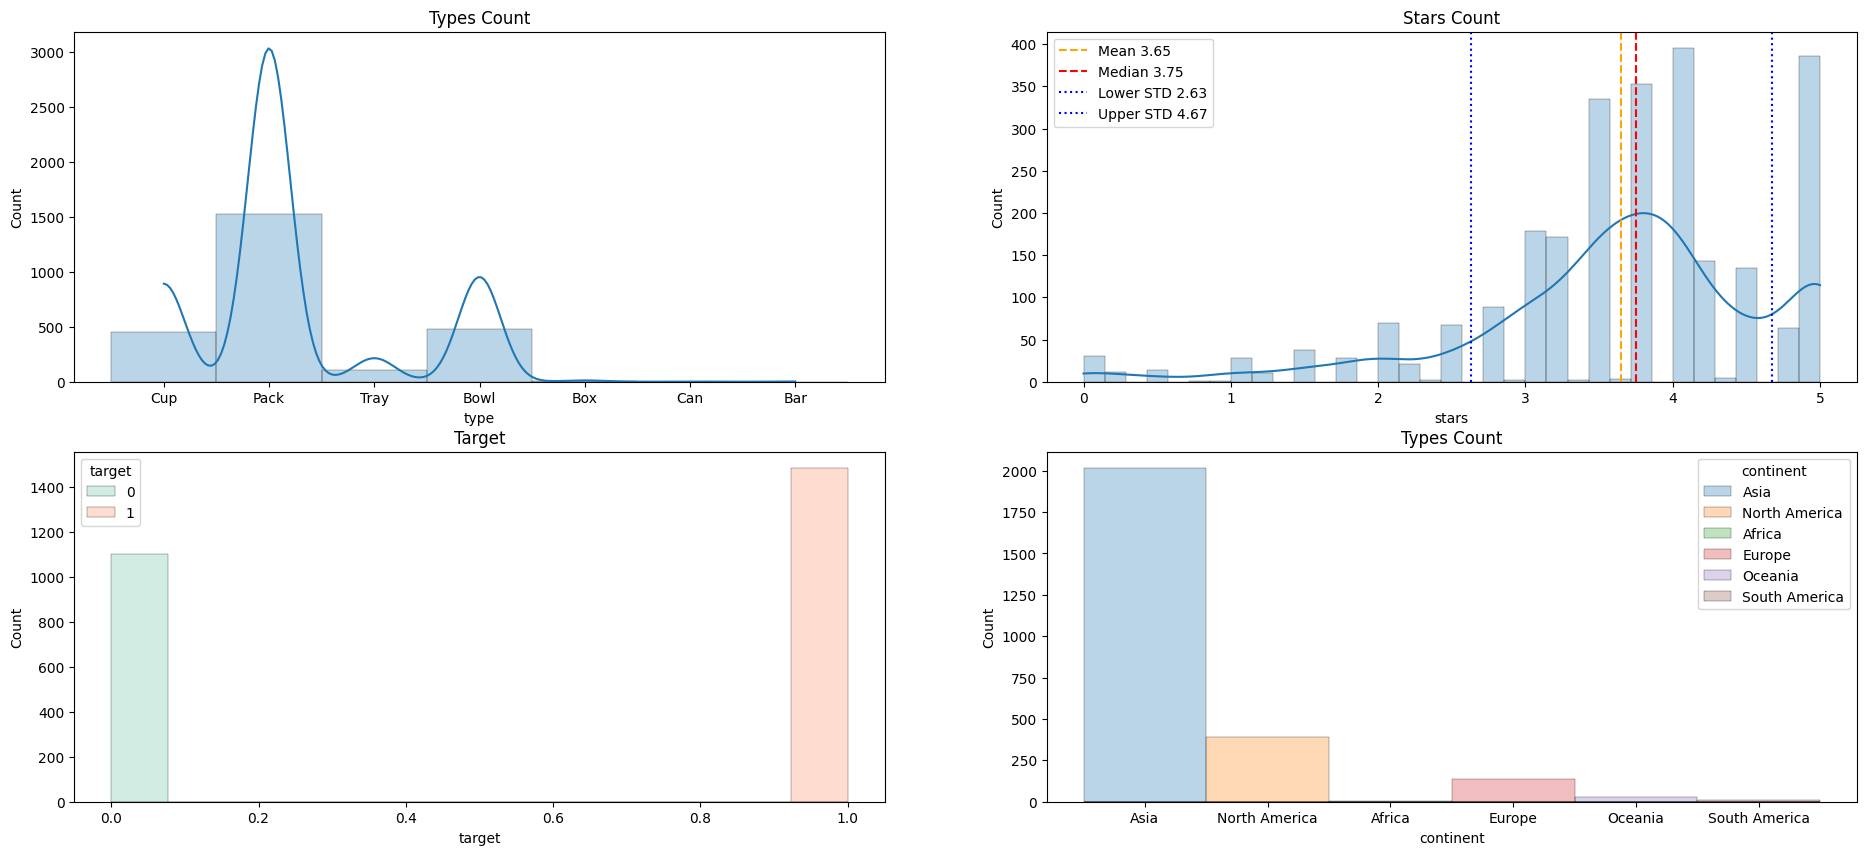

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(23,10))

#Histogramas
sns.histplot(types,ax=axs[0,0],alpha=0.3,lw=0.2,kde=True)
axs[0,0].set_title("Types Count")

sns.histplot(stars,ax=axs[0,1],alpha=0.3,lw=0.2,kde=True)
axs[0,1].axvline(stars.mean(),ls="dashed",color="orange",label=f"Mean {round(stars.mean(),2)}") #Mean
axs[0,1].axvline(stars.median(),ls="dashed",color="red",label=f"Median {round(stars.median(),2)}") #Median
axs[0,1].axvline(stars.mean()-stars.std(),ls="dotted",color="blue",label=f"Lower STD {round(stars.mean()-stars.std(),2)}") #LOWER STD
axs[0,1].axvline(stars.mean()+stars.std(),ls="dotted",color="blue",label=f"Upper STD {round(stars.mean()+stars.std(),2)}") #UPPER STD
axs[0,1].set_title("Stars Count")
axs[0,1].legend()

sns.histplot(data=df,x="target",ax=axs[1,0],alpha=0.3,lw=0.2,hue="target",palette="Set2")
axs[1,0].set_title("Target")

sns.histplot(data=df,x="continent",hue="continent",ax=axs[1,1],alpha=0.3,lw=0.2)
axs[1,1].set_title("Types Count")

Types = El tipo "pack", es por lejos el empaque/recipiente con mayor cantidad de reviews, seguido de bowl y cup.
Stars = Podemos ver que la media de estrellas en el dataset es de 3.65, con una desviación estandar bastante considerable de 1 (20% aprox). La distribución de esta variable se encuentra sesgada hacia la izquierda, lo que nos dice que la mayor cantidad de evaluaciones por estrellas son entre 3-5, con algunos outliers de valores como 0 y 1 probablemente.
Target = Como indicamos anteriormente, ambas clases se encuentran casi balanceadas, con una diferencia menor al 10%, lo que podemos corregir más adelante si obtenemos malas metricas de desempeño.
Continent = Podemos apreciar que la mayor cantidad de reviews en el dataset son de Asia, seguido de North America y Europa. Probablemente considerar la data de africa , oceania y south america para obtener conclusiones sería apresurado, ya que su presencia en el dataset no es notable como para poder hacer inferencias, por lo que hay que prestarles atención.

**Visualizacion de estrellas**

<ipython-input-16-2421ff420ea8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="continent",y="stars",hue_order="continent",palette="Set3",ax=axs[0])
<ipython-input-16-2421ff420ea8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x="type",y="stars",hue_order="types",palette="Set3",ax=axs[1])


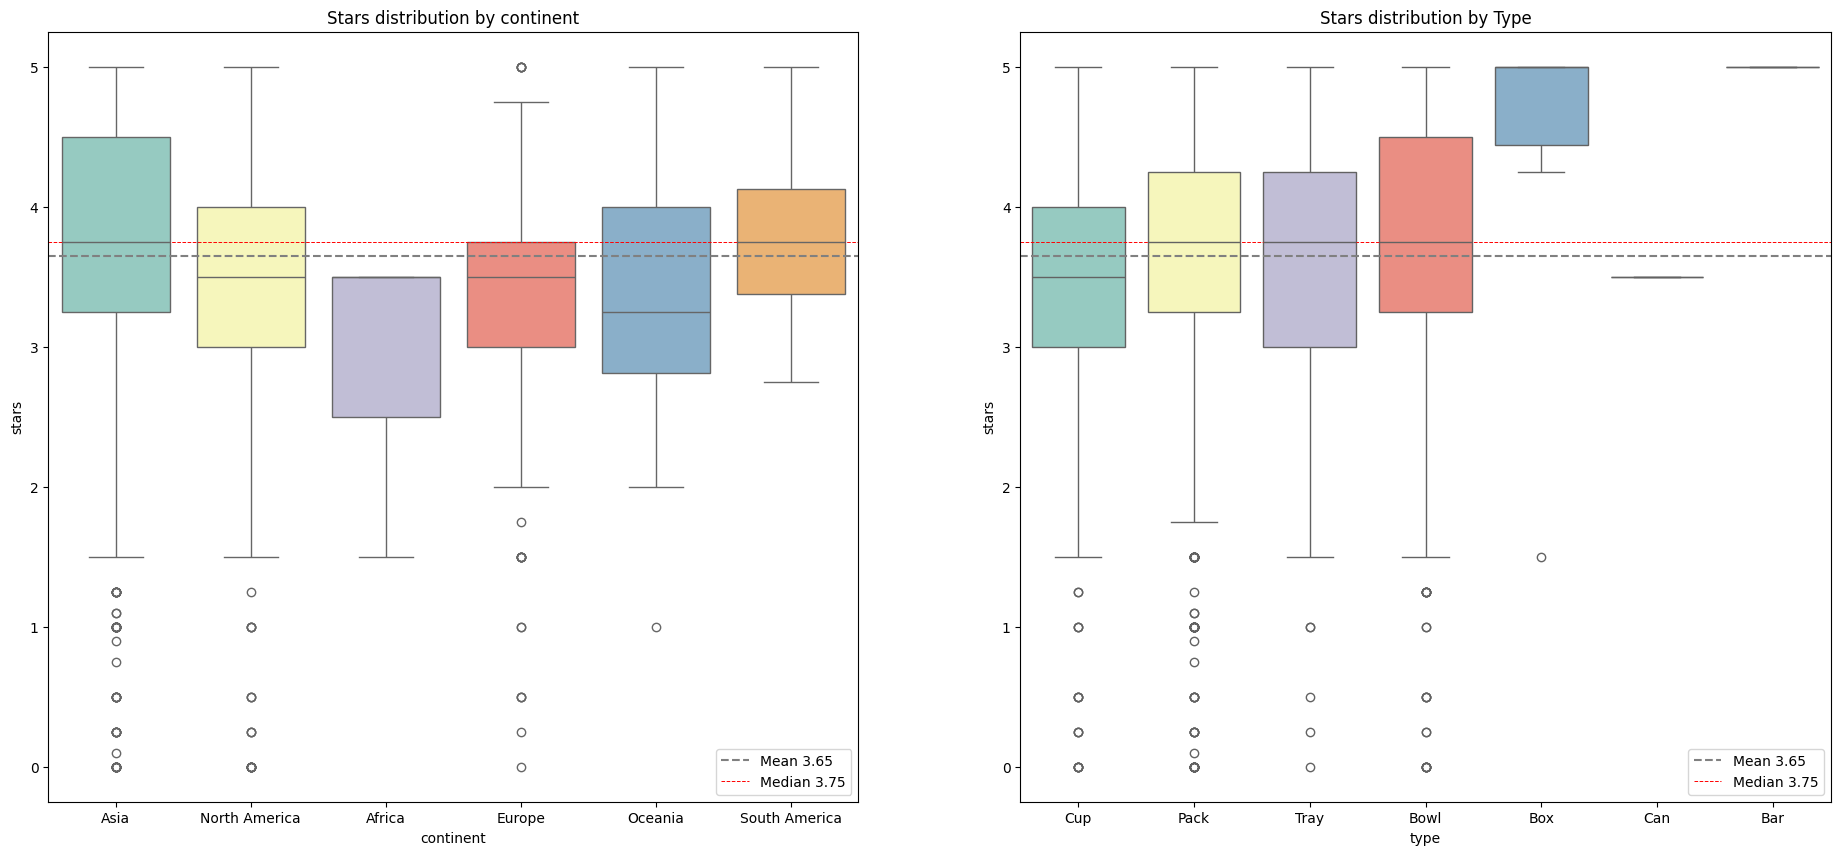

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(23,10))
sns.boxplot(data=df,x="continent",y="stars",hue_order="continent",palette="Set3",ax=axs[0])
axs[0].axhline(stars.mean(),ls="dashed",color="grey",label=f"Mean {round(stars.mean(),2)}") #mean
axs[0].axhline(stars.median(),ls="dashed",color="red",lw=0.7,label=f"Median {round(stars.median(),2)}") #median
axs[0].legend()
axs[0].set_title("Stars distribution by continent")

sns.boxplot(data=df,x="type",y="stars",hue_order="types",palette="Set3",ax=axs[1])
axs[1].axhline(stars.mean(),ls="dashed",color="grey",label=f"Mean {round(stars.mean(),2)}") #mean
axs[1].axhline(stars.median(),ls="dashed",color="red",lw=0.7,label=f"Median {round(stars.median(),2)}") #median
axs[1].legend()
axs[1].set_title("Stars distribution by Type")

plt.show()

**Stars by continent =** Como podemos ver todos los continentes en general siguen la tendencia global de stars, inclinandose hacia valores de puntuación por sobre la media y más cercanos a 4-5. Asia, quien tiene la mayor cantidad de review es quien tiene casi el 50% de sus datos entre 3.5-4.5, lo cual es bastante bueno. North america y europa se distribuyen más entre 2.8-4.0 aprox. El resto de continentes, como vimos anteriormente, al tener poca data, no podemos sacar conclusiones sobre su distribución, ya que al parecer los pocos datos que tienen, son con buena puntuación, pero no podriamos sacar una prediccion sobre la poblacion de productos tipo ramen de sus paises basados en esto.**
**Stars by Type** = Los bowls son los que tienen mejor distribución, entre 3.5-4.5, seguidos de cup, pack y tray. Sin embargo, al igual que los continentes, tenemos varias categorias como box, can, bar y el mismo tray, que con tan poca data, no deberian ser tan relevantes para poder hacer predicciones sobre la poblacion de estos productos, es decir, faltaría más data para poder comparar equitativamente, pero para efectos del ejercicio, seguiran considerandose.

**Revision de outliers**

In [ ]:
def clean_outliers(df,column):
  #cuartiles e iqr
  column_values = df[column]
  Q1 = np.quantile(column_values,0.25)
  Q3 = np.quantile(column_values,0.75)
  IQR = Q3-Q1
  #limites
  LOW = (Q1 - 1.5 * IQR)
  UP = (Q3 + 1.5 * IQR)

  df_clean = df[(df[column]>LOW) & (df[column]<UP)]

  return df_clean

df_clean = clean_outliers(df,"stars") #Limpiaremos nuestra unica columna numerica que por su naturaleza podria presentar outliers, el resto ya los revisamos y modificamos.

In [ ]:
shape_old = df.shape[0]
shape_clean = df_clean.shape[0]

print(f"El dataset pasó de tener {shape_old} registros a tener {shape_clean} luego de la limpieza de outliers.")

El dataset pasó de tener 2580 registros a tener 2421 luego de la limpieza de outliers.


#**2.Realizar el preprocesamiento de los datos, incluyendo la normalización o estandarización de las características, codificación de variables categóricas y división del conjunto de datos en conjuntos de entrenamiento y prueba.**

Como la columna top ten tenia más del 90% de valores nan, lo que haremos es transformarla a una columna booleana que nos indique si el review corresponde a top ten o no, siendo indiferente al ranking.

In [ ]:
df_clean

,review,brand,variety,type,country,stars,top_ten,continent,target
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN,Asia,1
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN,North America,0
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN,Asia,0
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN,Asia,1
5,2575,Samyang Foods,Kimchi song Song Ramen,Pack,South Korea,4.75,NaN,Asia,1
...,...,...,...,...,...,...,...,...,...
2572,8,Tung-I,Chinese Beef Instant Rice Noodle,Pack,Taiwan,3.00,NaN,Asia,0
2574,6,Vifon,Nam Vang,Pack,Vietnam,2.50,NaN,Asia,0
2575,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.50,NaN,Asia,0
2577,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2.00,NaN,Asia,0


In [ ]:
df_clean["top_ten_recoded"] = np.where(df_clean["top_ten"].isna(), 0,1 )
#Haremos un label encoder de las variables brand
label_encoder = LabelEncoder()
df_clean["brand_encoder"] = label_encoder.fit_transform(df_clean["brand"]) #Recodificamos brand para transformar todas las marcas a valores numericos, sin pesos, es solo etiquetas numericas.

<ipython-input-20-a935015462a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["top_ten_recoded"] = np.where(df_clean["top_ten"].isna(), 0,1 )
<ipython-input-20-a935015462a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["brand_encoder"] = label_encoder.fit_transform(df_clean["brand"]) #Recodificamos brand para transformar todas las marcas a valores numericos, sin pesos, es solo etiquetas numericas.


In [ ]:
df_clean

,review,brand,variety,type,country,stars,top_ten,continent,target,top_ten_recoded,brand_encoder
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN,Asia,1,0,176
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN,North America,0,0,178
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN,Asia,0,0,311
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN,Asia,1,0,36
5,2575,Samyang Foods,Kimchi song Song Ramen,Pack,South Korea,4.75,NaN,Asia,1,0,232
...,...,...,...,...,...,...,...,...,...,...,...
2572,8,Tung-I,Chinese Beef Instant Rice Noodle,Pack,Taiwan,3.00,NaN,Asia,0,0,294
2574,6,Vifon,Nam Vang,Pack,Vietnam,2.50,NaN,Asia,0,0,305
2575,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.50,NaN,Asia,0,0,305
2577,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2.00,NaN,Asia,0,0,308


**Transformaremos en binaria a través de dummies type y continent, para luego eliminar del dataset las variables que no serán usadas y/o ya fueron transfomradas.**

In [ ]:
to_get = ["type","continent"]
df_alg = pd.get_dummies(data=df_clean,columns=to_get)
df_alg

,review,brand,variety,country,stars,top_ten,target,top_ten_recoded,brand_encoder,type_Bar,...,type_Can,type_Cup,type_Pack,type_Tray,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America
0,2580,New Touch,T's Restaurant Tantanmen,Japan,3.75,NaN,1,0,176,0,...,0,1,0,0,0,1,0,0,0,0
2,2578,Nissin,Cup Noodles Chicken Vegetable,USA,2.25,NaN,0,0,178,0,...,0,1,0,0,0,0,0,1,0,0
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Taiwan,2.75,NaN,0,0,311,0,...,0,0,1,0,0,1,0,0,0,0
4,2576,Ching's Secret,Singapore Curry,India,3.75,NaN,1,0,36,0,...,0,0,1,0,0,1,0,0,0,0
5,2575,Samyang Foods,Kimchi song Song Ramen,South Korea,4.75,NaN,1,0,232,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,8,Tung-I,Chinese Beef Instant Rice Noodle,Taiwan,3.00,NaN,0,0,294,0,...,0,0,1,0,0,1,0,0,0,0
2574,6,Vifon,Nam Vang,Vietnam,2.50,NaN,0,0,305,0,...,0,0,1,0,0,1,0,0,0,0
2575,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Vietnam,3.50,NaN,0,0,305,0,...,0,0,0,0,0,1,0,0,0,0
2577,3,Wai Wai,Tom Yum Shrimp,Thailand,2.00,NaN,0,0,308,0,...,0,0,1,0,0,1,0,0,0,0


In [ ]:
df_alg.columns

Index(['review', 'brand', 'variety', 'country', 'stars', 'top_ten', 'target',
       'top_ten_recoded', 'brand_encoder', 'type_Bar', 'type_Bowl', 'type_Box',
       'type_Can', 'type_Cup', 'type_Pack', 'type_Tray', 'continent_Africa',
       'continent_Asia', 'continent_Europe', 'continent_North America',
       'continent_Oceania', 'continent_South America'],
      dtype='object')

In [ ]:
df_alg= df_alg.drop(columns=["review","brand","variety","country","top_ten"]) #Dropeamos las columnas que no utilizaremos
df_alg

,stars,target,top_ten_recoded,brand_encoder,type_Bar,type_Bowl,type_Box,type_Can,type_Cup,type_Pack,type_Tray,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America
0,3.75,1,0,176,0,0,0,0,1,0,0,0,1,0,0,0,0
2,2.25,0,0,178,0,0,0,0,1,0,0,0,0,0,1,0,0
3,2.75,0,0,311,0,0,0,0,0,1,0,0,1,0,0,0,0
4,3.75,1,0,36,0,0,0,0,0,1,0,0,1,0,0,0,0
5,4.75,1,0,232,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,3.00,0,0,294,0,0,0,0,0,1,0,0,1,0,0,0,0
2574,2.50,0,0,305,0,0,0,0,0,1,0,0,1,0,0,0,0
2575,3.50,0,0,305,0,1,0,0,0,0,0,0,1,0,0,0,0
2577,2.00,0,0,308,0,0,0,0,0,1,0,0,1,0,0,0,0


No estandarizaremos la variable brand encoder, ya que solo es una representacion numerica de una variable categorica, su magnitud no representa necesariamente algo.

#**3.Dividir los datos en conjuntos de entrenamiento y prueba y entrenar dos modelos de clasificación: uno utilizando Regresión Logística y otro utilizando Support Vector Machine (SVM). Estos modelos servirán para determinar si un paquete de ramen es "bueno" o "malo" en función de las características proporcionadas y realiza una búsqueda de hiperparámetros. 4. Evaluar el rendimiento usando  precisión, recall, F1-score y AUC-ROC, AUC-PR**

In [ ]:
df_alg

,stars,target,top_ten_recoded,brand_encoder,type_Bar,type_Bowl,type_Box,type_Can,type_Cup,type_Pack,type_Tray,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America
0,3.75,1,0,176,0,0,0,0,1,0,0,0,1,0,0,0,0
2,2.25,0,0,178,0,0,0,0,1,0,0,0,0,0,1,0,0
3,2.75,0,0,311,0,0,0,0,0,1,0,0,1,0,0,0,0
4,3.75,1,0,36,0,0,0,0,0,1,0,0,1,0,0,0,0
5,4.75,1,0,232,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,3.00,0,0,294,0,0,0,0,0,1,0,0,1,0,0,0,0
2574,2.50,0,0,305,0,0,0,0,0,1,0,0,1,0,0,0,0
2575,3.50,0,0,305,0,1,0,0,0,0,0,0,1,0,0,0,0
2577,2.00,0,0,308,0,0,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
desbalance = df_alg["target"].value_counts("%")
print(desbalance)

1    0.611731
0    0.388269
Name: target, dtype: float64


**Realizaremos un SMOTE para disminuir el desbalance de clase encontrado luego de la limpieza d outliers**

##**Regresión Logística**

In [ ]:
#Definimos las variables predictoras y objetivo
X = df_alg.drop(columns=["target","brand_encoder"])
feature_names = X.columns
y= df_alg["target"]

# Escalar las características para que tengan media 0 y desviación estándar 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Seleccionar solo dos características para el plot
feature1_idx = 0
feature2_idx = 1
X_2d = X_scaled[:, [feature1_idx, feature2_idx]]

#Dividimos el dataset en train y test.
X_train,X_test,y_train,y_test = train_test_split(X_2d, y, test_size=0.30,random_state=40)

#Realizamos el smote
smote = SMOTE(random_state=40)
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

#Instanciamos el modelo de regresion
log_reg = LogisticRegressionCV(cv=5,n_jobs=-1,max_iter=1000)
log_reg.fit(X_train_smote,y_train_smote)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1)

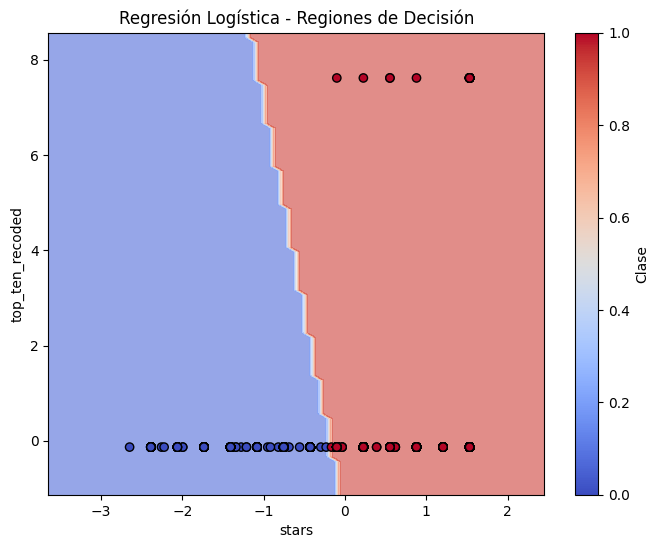

In [ ]:
#Obtener los coeficientes y el intercepto del modelo
coeficientes = log_reg.coef_
intercepto = log_reg.intercept_

# Crear un meshgrid para el plot
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
np.arange(y_min, y_max, 0.1))

# Predecir las clases para cada punto del meshgrid
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot de las regiones de decisión y los puntos de entrenamiento
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm,
edgecolors='k')
plt.xlabel(feature_names[feature1_idx])
plt.ylabel(feature_names[feature2_idx])
plt.title("Regresión Logística - Regiones de Decisión")
plt.colorbar(label="Clase")
plt.show()

**Aqui podemos ver que no existe necesariamente una relacion del tipo lineal entre features de ejemplo.**

In [ ]:
#Predecimos sobre TRAIN
y_train_pred = log_reg.predict(X_train_smote)

#Predecimos sobre TEST
y_test_pred = log_reg.predict(X_test)

#Calculamos AUC-ROC Y PR sobre TRAIN
log_train_auc = roc_auc_score(y_train_smote,y_train_pred)
log_train_pr = average_precision_score(y_train_smote,y_train_pred)

#Calculamos AUC-ROC Y PR sobre TEST
log_test_auc = roc_auc_score(y_test,y_test_pred)
log_test_pr = average_precision_score(y_test,y_test_pred)

#Informe de clasificacion
log_reporte_train = classification_report(y_train_smote,y_train_pred)
log_reporte_test = classification_report(y_test,y_test_pred)

#Accuracy
acc_log_train = accuracy_score(y_train_smote,y_train_pred)
acc_log_test = accuracy_score(y_test,y_test_pred)

print("AUC-ROC SOBRE TRAIN:",log_train_auc)
print("AUC-PR SOBRE TRAIN:",log_train_pr)
print("")
print("AUC-ROC SOBRE TEST:",log_test_auc)
print("AUC-PR SOBRE TEST:",log_test_pr)

print("")
print("___INFORME CLASIFICACION TRAIN______")
print(log_reporte_train)
print("")
print("___INFORME CLASIFICACION TEST_______")
print(log_reporte_test)

print("")
print("ACCURACY TRAIN:")
print(acc_log_train)
print("")
print("ACCURACY TEST")
print(acc_log_test)

AUC-ROC SOBRE TRAIN: 1.0
AUC-PR SOBRE TRAIN: 1.0

AUC-ROC SOBRE TEST: 1.0
AUC-PR SOBRE TEST: 1.0

___INFORME CLASIFICACION TRAIN______
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1032
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2064
   macro avg       1.00      1.00      1.00      2064
weighted avg       1.00      1.00      1.00      2064


___INFORME CLASIFICACION TEST_______
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       278
           1       1.00      1.00      1.00       449

    accuracy                           1.00       727
   macro avg       1.00      1.00      1.00       727
weighted avg       1.00      1.00      1.00       727


ACCURACY TRAIN:
1.0

ACCURACY TEST
1.0


In [ ]:
# Realizamos validación cruzada con cv=5, numero de folds
scores = cross_val_score(log_reg, X_train_smote, y_train_smote, cv=5, scoring='accuracy')

# Imprimimos los resultados de la validación cruzada
print("Puntuaciones de validación cruzada:", scores)
print("Precisión media:", scores.mean())


Puntuaciones de validación cruzada: [1. 1. 1. 1. 1.]
Precisión media: 1.0


**Resultados regresion logistica CV:**
**Como podemos apreciar tanto en metricas AUC-ROC,PR, Precision, recall, f1score y accuracy, el modelo de regresion logistica presenta un overfitting excesivo hacia los datos, este sobre ajuste nisiquiera fue posible de solucionar utilizando validacion cruzada para testeo de hiperparametros, lo que nos indica que probablemente este modelo no es lo suficientemente adecuado para capturar la probabilidad de prediccion de un buen o mal ramen. Es posible que existe una relacion NO LINEAL entre las features y el target, lo que es probable ya que casi todas las variables del dataset primitivo eran categoricas. Procederemos a utilizar un algoritmo de Support Vector Machine**

**Aplicaremos un pca para ver si mejoran las metricas de la regresion logistica**

In [ ]:
#Reducir la dimensionalidad de los datos de entrenamiento a 2 dimensiones usando PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_smote)

#Instanciamos otro modelo para no confundirnos
log_pca = LogisticRegressionCV(cv=5,n_jobs=-1,max_iter=1000)

#Entrenar el modelo en los datos reducidos
log_pca.fit(X_train_pca, y_train_smote)

#Predecimos sobre train
y_train_log_pca = log_pca.predict(X_train_pca)

#Predecimos sobre test
y_test_log_pca = log_pca.predict(X_test)

#Calculamos AUC-ROC Y PR sobre TRAIN
log_train_auc_pca = roc_auc_score(y_train_smote,y_train_log_pca)
log_train_pr_pca = average_precision_score(y_train_smote,y_train_log_pca)

#Calculamos AUC-ROC Y PR sobre TEST
log_test_auc_pca = roc_auc_score(y_test,y_test_log_pca)
log_test_pr_pca = average_precision_score(y_test,y_test_log_pca)

#Informe de clasificacion
log_reporte_train_pca = classification_report(y_train_smote,y_train_log_pca)
log_reporte_test_pca = classification_report(y_test,y_test_log_pca)

#Printeamos
print("AUC-ROC SOBRE TRAIN:",log_train_auc_pca)
print("AUC-PR SOBRE TRAIN:",log_train_pr_pca)
print("")
print("AUC-ROC SOBRE TEST:",log_test_auc_pca)
print("AUC-PR SOBRE TEST:",log_test_pr_pca)

print("")
print("___INFORME CLASIFICACION TRAIN______")
print(log_reporte_train_pca)
print("")
print("___INFORME CLASIFICACION TEST")
print(log_reporte_test_pca)

AUC-ROC SOBRE TRAIN: 1.0
AUC-PR SOBRE TRAIN: 1.0

AUC-ROC SOBRE TEST: 0.8496659242761693
AUC-PR SOBRE TEST: 0.8850264840406467

___INFORME CLASIFICACION TRAIN______
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1032
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2064
   macro avg       1.00      1.00      1.00      2064
weighted avg       1.00      1.00      1.00      2064


___INFORME CLASIFICACION TEST
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       278
           1       1.00      0.70      0.82       449

    accuracy                           0.81       727
   macro avg       0.84      0.85      0.81       727
weighted avg       0.88      0.81      0.82       727



Resultados post PCA : Todas las metricas evaluadas de auc,pr, accuracy, precision, recall, f1 score, podriamos deducir que "mejoraron", ya que ahora tienen parametros mucho más realistas y que no revelan un overfitting excesivo. El modelo es capaz de detectar y clasificar con precision y sensibilidad los tipos de ramen clasificados como buenos, con un f1 score de 0.82 lo cual es bastante bueno.

##**Support Vector Machine**

Primero haremos una busqueda de los mejores hiperparametros Kernel,C,Gamma:

In [ ]:
#Calculamos la precision global del modelo
accuracy_svc_train = accuracy_score(y_train_smote,y_train_svc_pred)
accuracy_svc_test = accuracy_score(y_test,y_test_svc_pred)

print("ACCURACY SVC TRAIN:",accuracy_svc_train)
print("ACCURACY SVC TEST:",accuracy_svc_test)

ACCURACY SVC TRAIN: 0.999515503875969
ACCURACY SVC TEST: 1.0


**Busqueda de hiperparametros a través de validacion cruzada**

In [ ]:
#A pesar de que intuimos que la relacion no es lineal, de todas formas igual incluiremos linear en la validacion cruzada
param_grid = {
    "kernel":['linear', 'rbf', 'poly'],
    "C": np.arange(1.0,10,0.1),
    "gamma": np.arange(0.1,10,0.1)
}

#Creamos un clasificador
svc = SVC(random_state=42)

#Configuramos la busqueda en cuadricula con validacion cruzada con gridsearch
grid_search = GridSearchCV(svc,param_grid,cv=5,scoring="accuracy")

#Ajustamos el modelo
grid_search.fit(X_train_smote,y_train_smote)

#Obtenermos los mejores hiperparametros
best_params = grid_search.best_params_
print("Mejores parametros para SVC:",best_params)

#Mejor modelo encontrado
best_model = grid_search.best_estimator_
print("Mejor modelo:",best_model)

Mejores parametros para SVC: {'C': 6.600000000000005, 'gamma': 9.6, 'kernel': 'rbf'}
Mejor modelo: SVC(C=6.600000000000005, gamma=9.6, random_state=42)


**Ahora que ya conocemos los mejores parametros, los utilizaremos para instanciar nuevamente el modelo y medir sus metricas de desempeño**

**Algoritmo SVC SIN PCA**

In [ ]:
#Instanciamos el modelo
svc_opt = SVC(kernel="rbf" , C=6.6 , gamma=9.6 , random_state=42)

#Entrenamos/ajustamos el modelo
svc_opt.fit(X_train_smote,y_train_smote)

#Predecimos sobre train
y_train_svc_pred = svc_opt.predict(X_train_smote)

#Predecimos sobre test
y_test_svc_pred = svc_opt.predict(X_test)

#Calculamos la precision global del modelo
accuracy_svc_train = accuracy_score(y_train_smote,y_train_svc_pred)
accuracy_svc_test = accuracy_score(y_test,y_test_svc_pred)

print("ACCURACY SVC SIN PCA, TRAIN:",accuracy_svc_train)
print("ACCURACY SVC SIN PCA, TEST:",accuracy_svc_test)

ACCURACY SVC SIN PCA, TRAIN: 1.0
ACCURACY SVC SIN PCA, TEST: 1.0


**Algoritmo SVC CON PCA**

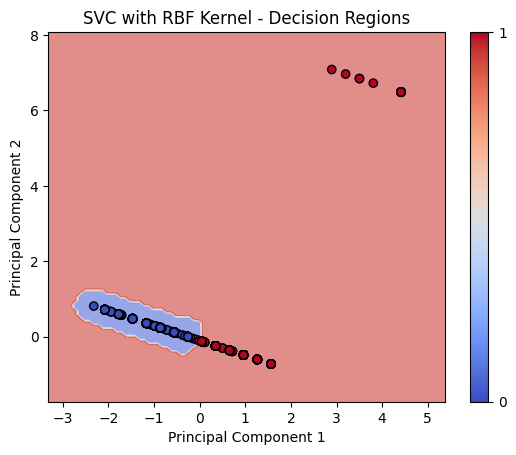


___________METRICAS DESEMPEÑO TRAIN_______________

ACCURACY SVC CON PCA TRAIN: 0.7422480620155039
AUC-ROC SOBRE TRAIN: 0.7422480620155039
AUC-PR SOBRE TRAIN: 0.6759809291090889

INFORME CLASIFICACION TRAIN:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      1032
           1       0.73      0.78      0.75      1032

    accuracy                           0.74      2064
   macro avg       0.74      0.74      0.74      2064
weighted avg       0.74      0.74      0.74      2064

___________METRICAS DESEMPEÑO TEST_______________

ACCURACY SVC CON PCA TEST: 0.7469050894085282
AUC-ROC SOBRE TEST: 0.7512617967986411
AUC-PR SOBRE TEST: 0.7784747976717545

INFORME CLASIFICACION TEST:
               precision    recall  f1-score   support

           0       0.64      0.77      0.70       278
           1       0.84      0.73      0.78       449

    accuracy                           0.75       727
   macro avg       0.74      0.75      0.

In [ ]:
#Reducir la dimensionalidad de los datos de entrenamiento a 2 dimensiones usando PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_smote)

#Entrenar el modelo SVC en los datos reducidos
svc_opt.fit(X_train_pca, y_train_smote)

#Crear un meshgrid para el plot
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

#Predecir las clases para cada punto del meshgrid
Z = svc_opt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#Plot de las regiones de decisión y los puntos de entrenamiento
plt.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_smote, cmap=plt.cm.coolwarm, edgecolors='k')
plt.colorbar(ticks=range(len(np.unique(y_train_smote))))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVC with RBF Kernel - Decision Regions')
plt.show()

#Predecir sobre los conjuntos de entrenamiento y prueba
y_train_svc_pred = svc_opt.predict(X_train_smote)
y_test_svc_pred = svc_opt.predict(X_test)

#Calcular la precisión global del modelo en ambos conjuntos
accuracy_pca_svc_train = accuracy_score(y_train_smote, y_train_svc_pred)
accuracy_pca_svc_test = accuracy_score(y_test, y_test_svc_pred)

#Calculamos AUC-ROC,PR
svc_auc_train = roc_auc_score(y_train_smote,y_train_svc_pred)
svc_auc_test = roc_auc_score(y_test,y_test_svc_pred)

svc_pr_train = average_precision_score(y_train_smote,y_train_svc_pred)
svc_pr_test = average_precision_score(y_test,y_test_svc_pred)

#Calculamos informe de clasificacion
svc_report_train = classification_report(y_train_smote,y_train_svc_pred)
svc_report_test = classification_report(y_test,y_test_svc_pred)

print("")
print("___________METRICAS DESEMPEÑO TRAIN_______________")
print("")
print("ACCURACY SVC CON PCA TRAIN:", accuracy_pca_svc_train)
print("AUC-ROC SOBRE TRAIN:",svc_auc_train)
print("AUC-PR SOBRE TRAIN:",svc_pr_train)
print("")
print("INFORME CLASIFICACION TRAIN:\n",svc_report_train)


print("___________METRICAS DESEMPEÑO TEST_______________")
print("")
print("ACCURACY SVC CON PCA TEST:", accuracy_pca_svc_test)
print("AUC-ROC SOBRE TEST:",svc_auc_test)
print("AUC-PR SOBRE TEST:",svc_pr_test)
print("")
print("INFORME CLASIFICACION TEST:\n",svc_report_test)

**Resultados finales: Luego de aplicar el algoritmo de Support Vector Machine con sus hiperparametros definidos a través de validacion cruzada, y darnos cuenta que el modelo se sigue sobre ajustando demasiado a los datos de entrenamiento y test, pudimos comprender que es necesario disminuir la complejidad del modelo a través de un PCA, con el objetivo de que el modelo no se sobre ajuste en exceso al ruido y la data propiamente tal con la que fue entrenada. Una vez graficado y calculado sus metricas de desempeño, podemos concluir que:**


Sobre las metricas de TEST, con la categoria 1 (buen ramen)

*   Con un accuracy de 0.74
*   Precision de 0.84
*   Recall de 0.73
*   F1 Score de 0.78
*   AUC ROC de 0.75 y AUC-PR de 0.77

**Podemos concluir que el modelo de Support Vector Machine tiene mejores metricas de desempeño a la hora de poder clasificar correctamente un ramen como bueno o malo a partir de las variable seleccionadas, esto se puede deber a que el SVM tiene mejor rendimiento frente a problemas de relaciones NO LINEALES COMPLEJAS, vs la regresion logistica que obtuvo un sobre ajuste tremendo el cual no es realista, entendiendo que no puede existir un modelo que tenga metricas de accuracy 1.0, ya que seria un modelo perfecto, por lo mismo, debido a esta ambivalencia entre un "falso" desempeño en train y un buen desempeño en test, es que el SVM presenta parametros mucho más realistas y coherentes a la hora de predecir si un ramen es bueno o malo.**


